# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [9]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [10]:
import random

random.seed(10)

#### Import experiment data 

In [11]:
from DATA import MG17

data = MG17(True, [80,10,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [12]:
N_UNITS = 50

In [13]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = False)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [14]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [15]:
ip_reservoir.pre_train(X_TR, eta=0.0000015, epochs=5,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 1592.9051513671875.
- Epoch: 2) | KL Divergence value: 1587.2012939453125.
- Epoch: 3) | KL Divergence value: 1581.486083984375.
- Epoch: 4) | KL Divergence value: 1575.742919921875.
- Epoch: 5) | KL Divergence value: 1569.9638671875.


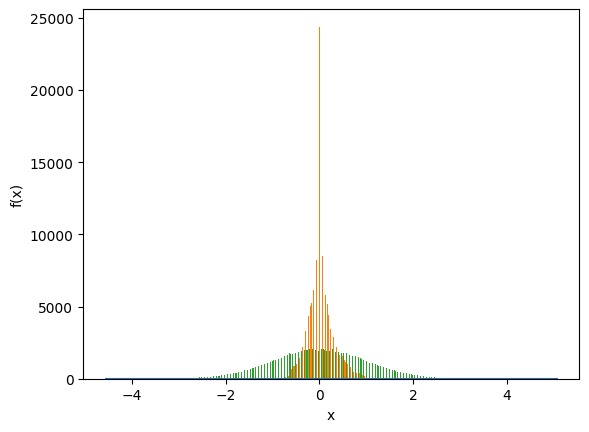

In [16]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [17]:
ip_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
ip_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

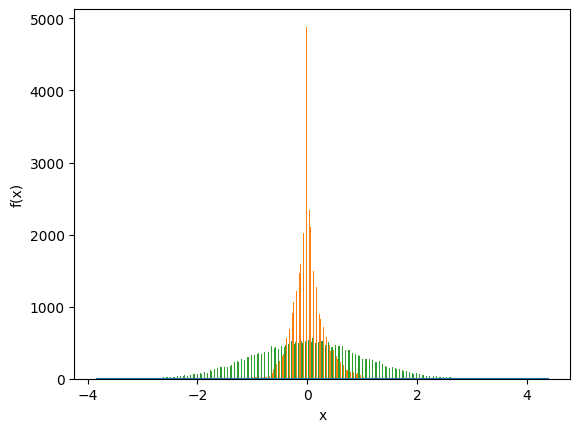

In [18]:
ip_reservoir.plot_global_neural_activity()

In [19]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.04431368038058281)  ACTUAL_STD == (0.15595585107803345)][ TARGET_MEAN == (-0.04838747903704643) TARGET_STD == (0.9980797171592712)]
Unit - (2): [ ACTUAL_MEAN == (0.11973955482244492)  ACTUAL_STD == (0.40991345047950745)][ TARGET_MEAN == (-0.01755482517182827) TARGET_STD == (0.9585376977920532)]
Overall network: [ACTUAL_MEAN == (0.02525080181658268)  ACTUAL_STD == (0.2786990702152252)]


## BIMODAL MIXTURE OF GAUSSIAN

In [20]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
# bimodal_reservoir.b_x = b_x
# bimodal_reservoir.b_u = b_u

In [21]:
bimodal_reservoir.pre_train(X_TR, eta=0.0000025, epochs=5,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3575.853759765625.
- Epoch: 2) | KL Divergence value: 3317.678955078125.
- Epoch: 3) | KL Divergence value: 3075.576416015625.
- Epoch: 4) | KL Divergence value: 2851.984619140625.
- Epoch: 5) | KL Divergence value: 2648.4296875.


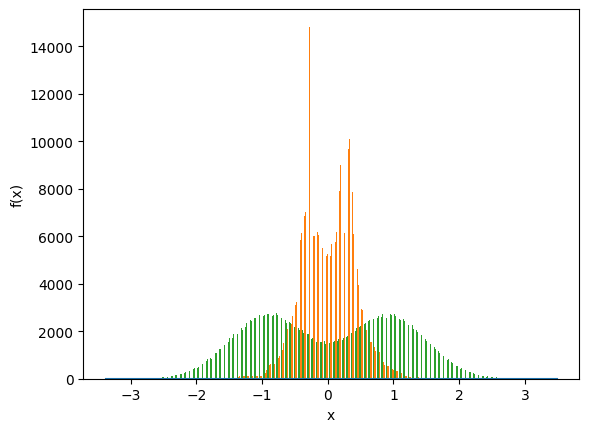

In [22]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [23]:
bimodal_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
bimodal_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

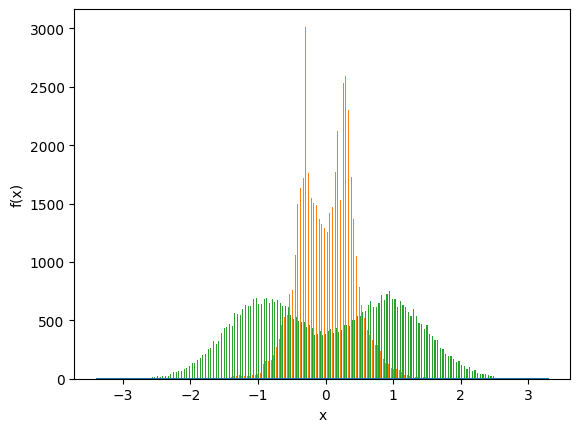

In [24]:
bimodal_reservoir.plot_global_neural_activity()

In [25]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.4314185678958893)  ACTUAL_STD == (0.16308651864528656)][ TARGET_MEAN == (-0.9198468327522278) TARGET_STD == (0.5935497879981995)]
Unit - (2): [ ACTUAL_MEAN == (0.360027015209198)  ACTUAL_STD == (0.42912423610687256)][ TARGET_MEAN == (0.908216655254364) TARGET_STD == (0.5807331204414368)]
Overall network: [ACTUAL_MEAN == (0.025072142481803894)  ACTUAL_STD == (0.39472949504852295)]


## EVAUALTUION IN ESN

In [26]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

from Metrics import NRMSE, MSE

### HANDMADE UGLY LAMBDA SEARCH

NORMALIZED ROOT-MEAN SQUARE ERROR: 6.968656627279138e-05


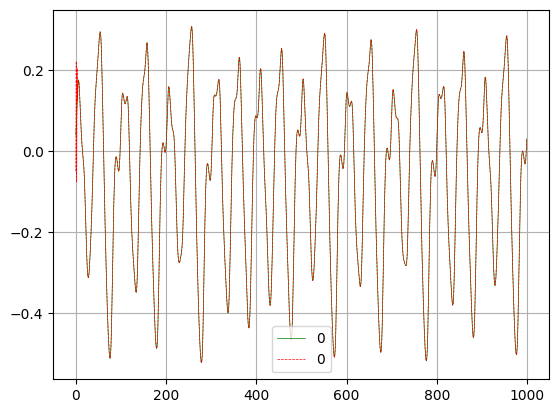

In [27]:
simple_esn.train(X_TR, Y_TR, 0)

#simple_esn.readout.predict(simple_esn.reservoir.predict(X_TR))

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 5.459635960066018e-06


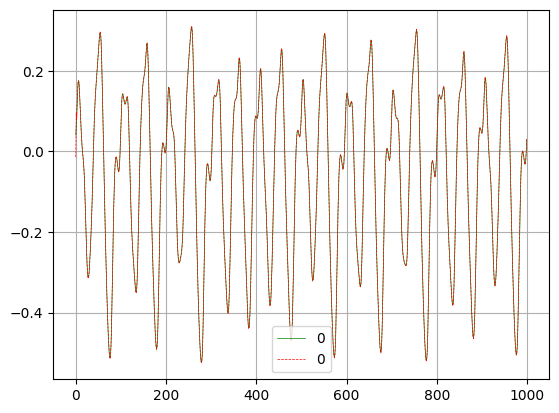

In [28]:

ip_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 4.649776333152436e-06


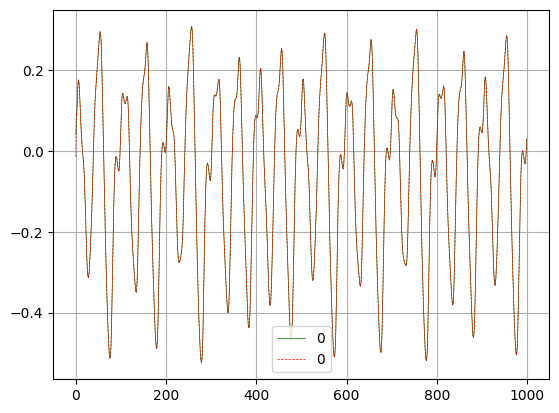

In [29]:
bimodal_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

### COMPARISON ON TEST DATA

NORMALIZED ROOT-MEAN SQUARE ERROR: 5.266511156500651e-05


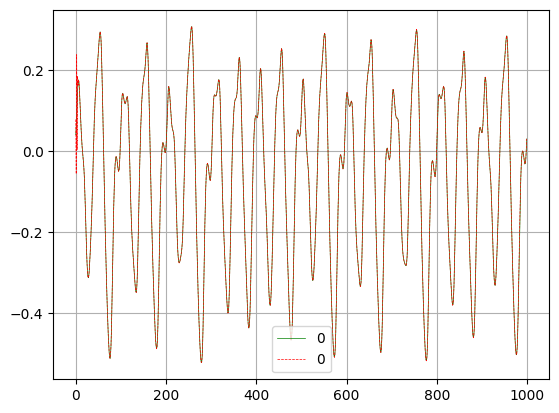

In [30]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 4.9635234350838855e-06


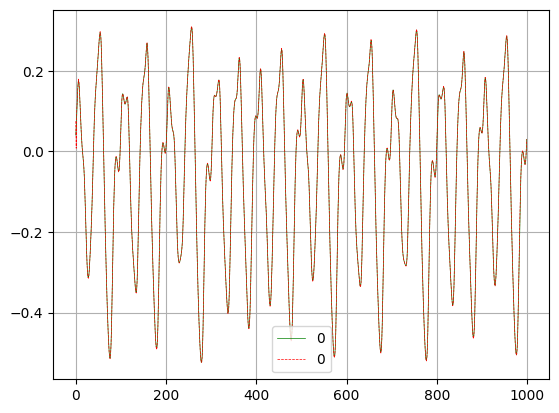

In [31]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 4.143104412554884e-06


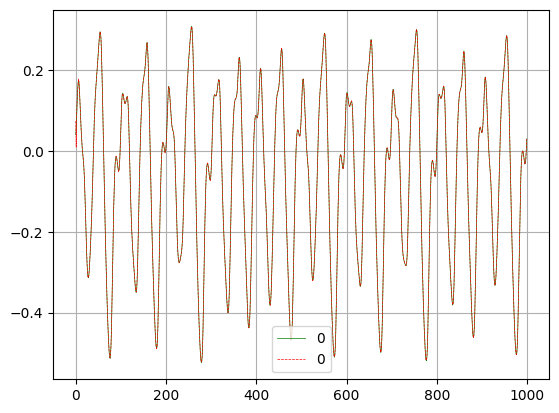

In [32]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

## MEMORY CAPACITY

In [33]:
simple_esn.MemoryCapacity(200,50)

tensor(2.3605)

In [34]:
ip_esn.MemoryCapacity(200,50)

tensor(2.7635)

In [35]:
bimodal_esn.MemoryCapacity(200,50)

tensor(1.9821)